# Loading Dataset:

In [1]:
# !git clone "https://github.com/muhammedtalo/COVID-19.git"
# !mv "COVID-19/X-Ray Image DataSet" "."

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/MyDrive/COVID Project - Summer 2022/Colab_Notebooks'

AlexNet  GoogleNet  Pneumonia	      ResNet50_dropout	VGG16_v2
covid	 normal     ResNet18_dropout  VGG16


In [4]:
our_covid_dataset = '/content/drive/MyDrive/COVID Project - Summer 2022/Colab_Notebooks/covid'

Kaggle Dataset:
Dataset link is: `https://drive.google.com/file/d/1bum9Sehb3AzUMHLhBMuowPKyr_PCrB3a/view?usp=sharing`

In [5]:
!pip install gdown
!gdown 1bum9Sehb3AzUMHLhBMuowPKyr_PCrB3a

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1bum9Sehb3AzUMHLhBMuowPKyr_PCrB3a
To: /content/COVID-19_Radiography_Dataset.zip
100% 814M/814M [00:28<00:00, 28.9MB/s]


In [6]:
!unzip COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [7]:
from pathlib import Path

kaggle_dataset = Path('COVID-19_Radiography_Dataset')

In [8]:
# add other sources of images here:
data = {'covid': [our_covid_dataset, kaggle_dataset / "COVID/images"],
        'normal': [kaggle_dataset / "Normal/images"],
        'pneumonia': [kaggle_dataset / "Viral Pneumonia/images"], }

In [9]:
!rm -r dataset

# create gathered dataset
import os
from distutils.dir_util import copy_tree

DATASET_ROOT = Path('dataset')
os.mkdir(DATASET_ROOT)
for image_class, image_sources in data.items():
    class_path = DATASET_ROOT / image_class
    print(str(class_path))
    os.mkdir(class_path)
    if not isinstance(image_sources, list):
        image_sources = [image_sources]
    for source in image_sources:
        copy_tree(source, str(class_path))

rm: cannot remove 'dataset': No such file or directory
dataset/covid
dataset/normal
dataset/pneumonia


Loading pretrained model:

In [10]:
!git clone "https://github.com/arnoweng/CheXNet.git"
!mv "./CheXNet/model.pth.tar" "."

Cloning into 'CheXNet'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 62 (delta 6), reused 5 (delta 5), pack-reused 52
Unpacking objects: 100% (62/62), done.


In [11]:
# DATASET_ROOT = 'dataset'
PRETRAINED_MODEL = 'model.pth.tar'

# Importing from libraries:

In [12]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import re

import numpy as np
import pandas as pd
import time

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import InterpolationMode
from torchvision.datasets import VOCSegmentation
from torchvision import models

Imports from my code:

In [13]:
%load_ext autoreload
%autoreload 2

Setting seed:

In [14]:
torch.manual_seed(24)
np.random.seed(24)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model:

In [16]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, weights=True):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121()
        num_features = self.densenet121.classifier.in_features
        if weights:
            self.densenet121.classifier = nn.Sequential(
                nn.Linear(num_features, 14)
            )
            load_weights(self)
        self.densenet121.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.densenet121(x)
        return x


def load_weights(model, device='cpu'):
    # Code modified from torchvision densenet source for loading from pre .4 densenet weights.
    checkpoint = torch.load(PRETRAINED_MODEL, map_location=torch.device(device))
    state_dict = checkpoint['state_dict']
    remove_data_parallel = True  # Change if you don't want to use nn.DataParallel(model)

    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
    for key in list(state_dict.keys()):
        match = pattern.match(key)
        new_key = match.group(1) + match.group(2) if match else key
        new_key = new_key[7:] if remove_data_parallel else new_key
        state_dict[new_key] = state_dict[key]
        # Delete old key only if modified.
        if match or remove_data_parallel:
            del state_dict[key]

    model.load_state_dict(state_dict)

Loading pretrained model:

In [17]:
model = DenseNet121(3).to(device)
model

DenseNet121(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

# Dataset:

Dataset for loading images:

In [18]:
class CovidDataset(Dataset):
    def __init__(self, root, transform=None, shuffle=True, balanced=False, clamp=None):
        if not isinstance(root, Path):
            root = Path(root)
        self.root = root
        self.transform = transform
        data = []
        for y in os.listdir(self.root):
            for x in os.listdir(os.path.join(self.root, y)):
                data.append({'image': x, 'label': y})
        self.dataframe = pd.DataFrame(data)
        self.label_names, labels = np.unique(self.dataframe['label'], return_inverse=True)
        self.label_to_index = {label_name: index for index, label_name in enumerate(self.label_names)}
        self.dataframe['label'] = labels
        self.original_label_counts = self.dataframe['label'].value_counts()
        if balanced:
            grouped_df = self.dataframe.groupby('label')
            self.dataframe = grouped_df.apply(lambda class_df: class_df.sample(grouped_df.size().min()).reset_index(drop=True))
        elif clamp is not None:
            clamp_count = self.original_label_counts[self.label_to_index[clamp]]
            grouped_df = self.dataframe.groupby('label')
            self.dataframe = pd.concat([class_df.sample(n=clamp_count) if len(class_df) > clamp_count else class_df for key, class_df in grouped_df])
        if shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)
        self.label_counts = self.dataframe['label'].value_counts()
        self.label_weights = len(self.dataframe) / self.label_counts
        self.label_weights = self.label_weights / self.label_weights.sum()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        item = self.dataframe.loc[index]
        image_name, label = item['image'], item['label']
        label_name = self.label_names[label]
        image_path = self.root / label_name / image_name
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [19]:
normalize = T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])

# dataset = CovidDataset(DATASET_ROOT, transform=T.Compose([
#                                     T.Resize(256),
#                                     T.TenCrop(224),
#                                     T.Lambda
#                                     (lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops])),
#                                     T.Lambda
#                                     (lambda crops: torch.stack([normalize(crop) for crop in crops]))
#                                 ]))
dataset = CovidDataset(DATASET_ROOT, clamp='covid',
                       transform=T.Compose([
                           T.Resize((256, 256)),
                           T.ToTensor(),
                           normalize
                       ]))

In [20]:
dataset.label_names

array(['covid', 'normal', 'pneumonia'], dtype=object)

In [21]:
dataset.label_to_index

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [22]:
dataset.original_label_counts

1    10192
0     4187
2     1345
Name: label, dtype: int64

In [23]:
#after clamping:
dataset.label_counts

0    4187
1    4187
2    1345
Name: label, dtype: int64

In [24]:
dataset.label_weights

0    0.195579
1    0.195579
2    0.608841
Name: label, dtype: float64

In [25]:
dataset[0][0].shape

torch.Size([3, 256, 256])

In [26]:
model(dataset[0][0].to(device).unsqueeze(0))

tensor([[-0.2431,  0.0313,  0.0891]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Dataloaders:

In [27]:
# splitting train and test sets
voc_len = len(dataset)
train_len = int(0.8 * voc_len)
test_len = voc_len - train_len
train_set, test_set = random_split(dataset, [train_len, test_len])

In [28]:
# splitting train and val sets
train_len = int(0.8 * len(train_set))
val_len = len(train_set) - train_len
train_set, val_set = random_split(train_set, [train_len, val_len])

In [29]:
train_loader = DataLoader(train_set, 64, shuffle=True)
val_loader = DataLoader(val_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

# Training:

Training functions:

In [ ]:
import time, tqdm


def train(model, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    N_train = len(train_loader.dataset)

    model.train()
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (x, y) in pbar:
            optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y)
            train_loss += loss.item() * len(x)

            pbar.set_description(f'Epoch:{epoch}, Train Loss: {train_loss / N_train:.3e}')

            loss.backward()
            optimizer.step()

    train_loss /= N_train
    return train_loss


def validate(model, val_loader, criterion, epoch=0, metrics=None):
    val_loss = 0
    N_val = len(val_loader.dataset)
    Y = []
    Y_pred = []
    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = model(x)
            y_pred = p.argmax(dim=-1)
            loss = criterion(p, y)
            val_loss += loss.item() * len(x)

            pbar.set_description(f'Epoch:{epoch}, Val Loss: {val_loss / N_val:.3e}')
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    val_loss /= N_val
    result = {'loss': val_loss}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})
    return result

In [ ]:
train_losses, val_losses = list(), list()

In [ ]:
def train_model(model, criterion, dataloaders, optimizer, num_epochs,
                model_name='pytorch_model', validation_metrics=None,
                scheduler=None):
    val = len(dataloaders) == 2
    if val:
        train_loader, val_loader = dataloaders
    else:
        train_loader, = dataloaders

    if validation_metrics is None:
        validation_metrics = dict()

    metrics_history = {metric: [] for metric in validation_metrics}
    val_loss_min = np.inf

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, epoch)
        train_losses.append(train_loss)
        if val:
            result = validate(model, val_loader, criterion, epoch, metrics=validation_metrics)
            val_loss = result['loss']
            val_losses.append(val_loss)
            for metric, metric_history in metrics_history:
                metric_history.append(result[metric])

            if val_loss <= val_loss_min:
                torch.save(model.state_dict(), f'{model_name}.pt')
                val_loss_min = val_loss
        if scheduler is not None:
            scheduler.step(val_loss)
        print('\n', '---' * 20)
    plt.plot(train_losses, label='train')
    if val:
        # load best model during different epochs
        model.load_state_dict(torch.load(f'{model_name}.pt'))
        plt.plot(val_losses, label='val')
        if len(metrics_history):
            plt.legend()
            plt.show()
            for metric, metric_history in metrics_history:
                plt.plot(metric_history, label=metric)
    plt.legend()
    plt.show()

    return model

Freezing pretrained layers:

In [ ]:
# model = model.to(device)
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.densenet121.classifier.parameters():
#     param.requires_grad = True

Learning Config:

In [ ]:
weighted_loss = False
if weighted_loss:
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(dataset.label_weights.sort_index().tolist())).to(device)
else:
    criterion = nn.CrossEntropyLoss().to(device)

## Overfitting on a small dataset:

In [ ]:
small_len = int(0.05 * len(train_set))
print(small_len)
other_len = len(train_set) - small_len
_, small_set = random_split(train_set, [other_len, small_len])
small_loader = DataLoader(small_set, 64, shuffle=True)

311


Epoch:0, Train Loss: 3.020e-01: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]



 ------------------------------------------------------------


Epoch:1, Train Loss: 1.828e-01: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]



 ------------------------------------------------------------


Epoch:2, Train Loss: 1.371e-01: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]



 ------------------------------------------------------------


Epoch:3, Train Loss: 9.881e-02: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:4, Train Loss: 6.958e-02: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



 ------------------------------------------------------------


Epoch:5, Train Loss: 4.901e-02: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



 ------------------------------------------------------------


Epoch:6, Train Loss: 4.629e-02: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



 ------------------------------------------------------------


Epoch:7, Train Loss: 2.726e-02: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



 ------------------------------------------------------------


Epoch:8, Train Loss: 2.180e-02: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



 ------------------------------------------------------------


Epoch:9, Train Loss: 2.015e-02: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:10, Train Loss: 1.952e-02: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]



 ------------------------------------------------------------


Epoch:11, Train Loss: 1.234e-02: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



 ------------------------------------------------------------


Epoch:12, Train Loss: 1.082e-02: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



 ------------------------------------------------------------


Epoch:13, Train Loss: 9.020e-03: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]



 ------------------------------------------------------------


Epoch:14, Train Loss: 8.022e-03: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:15, Train Loss: 5.932e-03: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



 ------------------------------------------------------------


Epoch:16, Train Loss: 6.404e-03: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:17, Train Loss: 4.531e-03: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:18, Train Loss: 5.087e-03: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



 ------------------------------------------------------------


Epoch:19, Train Loss: 3.617e-03: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:20, Train Loss: 4.039e-03: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:21, Train Loss: 3.303e-03: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:22, Train Loss: 2.940e-03: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]



 ------------------------------------------------------------


Epoch:23, Train Loss: 2.985e-03: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]



 ------------------------------------------------------------


Epoch:24, Train Loss: 2.715e-03: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]



 ------------------------------------------------------------


Epoch:25, Train Loss: 2.509e-03: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:26, Train Loss: 2.380e-03: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:27, Train Loss: 2.474e-03: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:28, Train Loss: 2.054e-03: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



 ------------------------------------------------------------


Epoch:29, Train Loss: 2.579e-03: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


 ------------------------------------------------------------


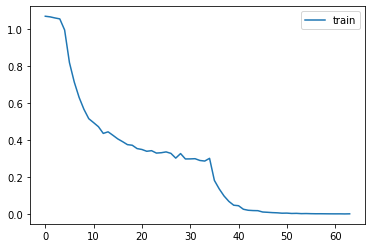

In [ ]:
lr = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
train_model(model, criterion, [small_loader], optimizer, 30);

In [ ]:
validate(model, small_loader, criterion, metrics={'accuracy': lambda y1, y2: (y1 == y2).mean()})

Epoch:0, Val Loss: 8.992e-04: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


{'loss': 0.0008991733120403992, 'accuracy': 1.0}

Overfitted (with lr=1e-3 for 30 epochs and lr=1e-4 for another 30 epochs).

## Tuning hyper-parameters:

In [ ]:
# todo!

## Training model:

In [ ]:
# reinitialize model and losses
train_losses.clear()
val_losses.clear()
model = DenseNet121(3).to(device)

In [ ]:
# # freeze first layers:
# model = model.to(device)
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.densenet121.classifier.parameters():
#     param.requires_grad = True

In [ ]:
lr = 1e-3
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True)

Epoch:0, Val Loss: 1.460e-01: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



 ------------------------------------------------------------


Epoch:1, Val Loss: 7.275e-02: 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]



 ------------------------------------------------------------


Epoch:2, Val Loss: 9.994e-02: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



 ------------------------------------------------------------


Epoch:3, Val Loss: 8.824e-02: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



 ------------------------------------------------------------


Epoch:4, Val Loss: 6.329e-02: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s]



 ------------------------------------------------------------


Epoch:5, Val Loss: 5.656e-02: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]



 ------------------------------------------------------------


Epoch:6, Val Loss: 5.515e-02: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]



 ------------------------------------------------------------


Epoch:7, Val Loss: 4.865e-02: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



 ------------------------------------------------------------


Epoch:8, Val Loss: 7.108e-02: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



 ------------------------------------------------------------


Epoch:9, Val Loss: 7.495e-02: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



 ------------------------------------------------------------


Epoch:10, Val Loss: 9.186e-02: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



 ------------------------------------------------------------


Epoch:11, Val Loss: 1.830e-01: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



 ------------------------------------------------------------


Epoch:12, Val Loss: 7.562e-02: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


Epoch 00013: reducing learning rate of group 0 to 2.0000e-04.

 ------------------------------------------------------------


Epoch:13, Val Loss: 4.116e-02: 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]



 ------------------------------------------------------------


Epoch:14, Val Loss: 3.805e-02: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



 ------------------------------------------------------------


Epoch:15, Val Loss: 4.192e-02: 100%|██████████| 25/25 [00:12<00:00,  1.93it/s]



 ------------------------------------------------------------


Epoch:16, Val Loss: 3.988e-02: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



 ------------------------------------------------------------


Epoch:17, Val Loss: 3.725e-02: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



 ------------------------------------------------------------


Epoch:18, Val Loss: 3.926e-02: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



 ------------------------------------------------------------


Epoch:19, Val Loss: 4.480e-02: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



 ------------------------------------------------------------


Epoch:20, Val Loss: 3.743e-02: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



 ------------------------------------------------------------


Epoch:21, Val Loss: 3.645e-02: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]



 ------------------------------------------------------------


Epoch:22, Val Loss: 3.655e-02: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



 ------------------------------------------------------------


Epoch:23, Val Loss: 3.888e-02: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



 ------------------------------------------------------------


Epoch:24, Val Loss: 3.961e-02: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]



 ------------------------------------------------------------


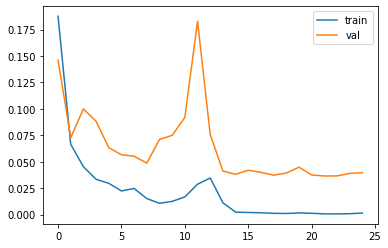

In [38]:
model = train_model(model, criterion, [train_loader, val_loader], optimizer, 25, 'covid-classification', scheduler=scheduler);

# Evaluation:

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}

Epoch:0, Val Loss: 4.765e-02: 100%|██████████| 31/31 [00:19<00:00,  1.57it/s]


{'loss': 0.04764534096083117,
 'accuracy': 0.9876543209876543,
 'precision': 0.9849377056659238,
 'recall': 0.9871796915671945,
 'f1': 0.9860472933024055}

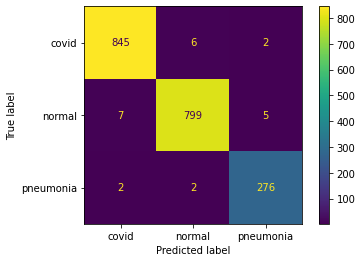

In [45]:
test_results = validate(model, test_loader, criterion, metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
test_results

Epoch:0, Val Loss: 1.162e-04: 100%|██████████| 98/98 [00:51<00:00,  1.89it/s]


{'loss': 0.00011619599776273167,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1': 1.0}

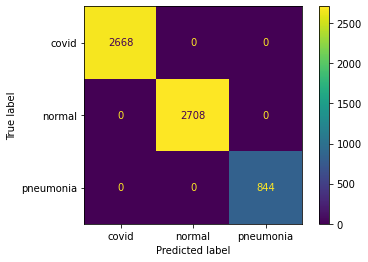

In [46]:
# on training set:
train_results = validate(model, train_loader, criterion, metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
train_results

Epoch:0, Val Loss: 3.645e-02: 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]


{'loss': 0.03644578689260115,
 'accuracy': 0.9935691318327974,
 'precision': 0.9919949934942438,
 'recall': 0.9929868972665732,
 'f1': 0.9924890802487374}

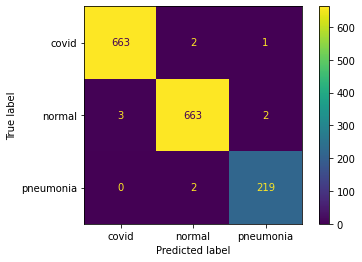

In [47]:
# on val set:
val_results = validate(model, val_loader, criterion, metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=dataset.label_names)
disp.plot()
val_results

In [41]:
# from google.colab import files

# files.download('covid-classification.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>